# Chapter 6. Deploying your API to the Cloud

It sounds a little extreme, but in this day and age, if your work isn’t online, it doesn’t exist.

Austin Kleon, Show Your Work! 10 Ways to Share Your Creativity and Get Discovered (Workman, 2014)

You have made great progress with your first API. You have selected the most important qualities for your users, developed multiple API endpoints, and created user-friendly documentation. In this chapter, you will publish your API to the cloud, where consumers can access it. This is another chance to share what you have been working on.

https://ryandaydev.medium.com/using-apis-with-ai-tell-me-all-the-ways-3f81fb06eca9

This chapter includes instructions for deploying to two cloud hosts, and I would encourage you to try out both of them to see the advantages and disadvantages of each. You will begin by using Render, which is fairly simple to deploy. Then, you will install and configure the Docker containerization tool, which you will use to deploy to Amazon Web Services (AWS).

| Software or service name | Version | Purpose |
| :--- | :---: | :--- |
| `Amazon Lightsail` | `NA` | AWS virtual cloud server |
| `AWS CLI` | `2.15` | Command-line interface for AWS services |
| `Docker` | `24.0` | Pack and run your application in a container |
| `Render` | `NA` | Cloud hosting provider |

# Deploying to Render

Render calls itself "a unified cloud to build and run all your apps and websites."

c7r5iklh

At the time of this writing, Render has a pricing plan that includes Python hosting for free, execept for a small cost for monthly storage. You will be generally following the instuctions from [Deploy a FastAPI App](https://oreil.ly/nmdaK)

The process of deploying to Render only involves a few steps, as shown here:

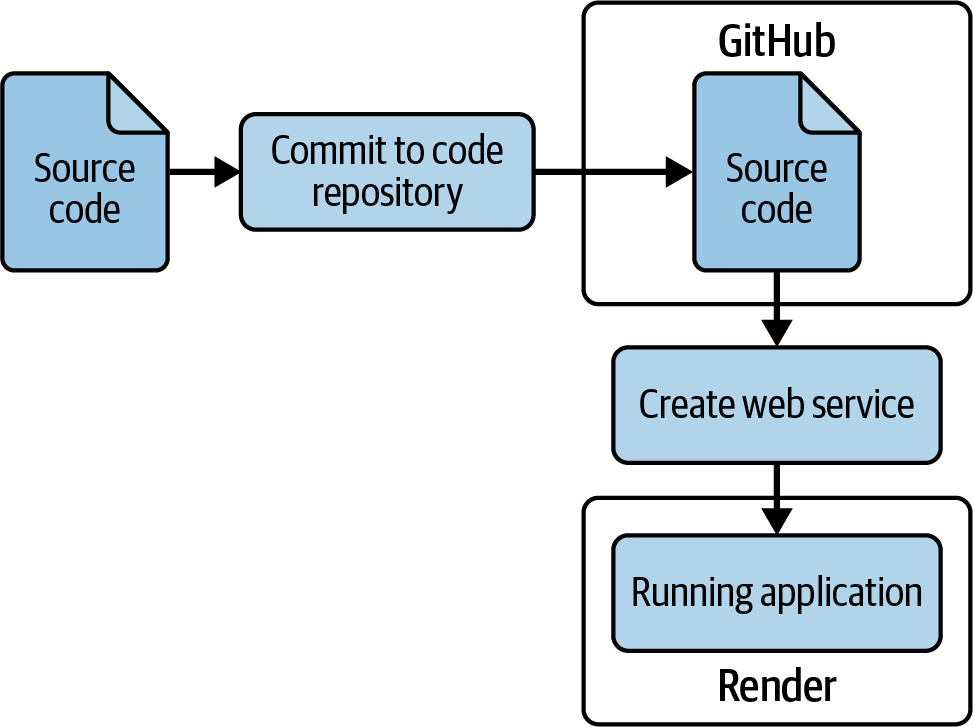

# Shipping Your Application in a Docker Container

Whereas Render deployed your application from a source code repository (GitHub), AWS will use an application named Docker. Docker is a very useful tool for shipping applications in containers. Just as cargo is shipped in a shipping container, applications are shipped in a software container.

The Docker glossary explains a few key terms that you will use. A Dockerfile is “a text document that contains all the commands you would normally execute manually to build a Docker image.” The container image, or Docker image, is “an ordered collection of root filesystem changes and the corresponding execution parameters for use within a container runtime.” A repository is a set of Docker images. A container runtime is software that uses the image to create a container, which is a runtime instance of a container image. You will use Docker as your container runtime.

The Docker glossary explains a few key terms that you will use. A Dockerfile is “a text document that contains all the commands you would normally execute manually to build a Docker image.” The container image, or Docker image, is “an ordered collection of root filesystem changes and the corresponding execution parameters for use within a container runtime.” A repository is a set of Docker images. A container runtime is software that uses the image to create a container, which is a runtime instance of a container image. You will use Docker as your container runtime.